# CS188 Assignment 1-2: Linear Regression & Logistic Regression & Softmax Regression

Before we start, please put your name and UD in following format

: Firstname LASTNAME, #00000000   //   e.g.) Yining Hong, #000000000

**Your Answer:**   
Kevin TANG, #805419480

In this notebook you will implement a Linear Regression & Logistic Regression on the tinyplaces dataset you created.

Recall that the Linear Regression does the following:
- Use linear function to model the relationship between an input and an output
- Use loss function to minimize the weight and bias of the linear function. In this assignment, we use Mean Squared Error as the loss function.

Logistic Regression takes a step further by adding a logistic function to the linear output. Here, we use Cross-Entropy Loss to optimize logistic regression.

Logistic Regression and Linear regression are for binary classification. For multi-class classification, we use Softmax Regression. Softmax Regression is an extension for linear regression where we add a softmax function to the linear output, and use NLL-loss to optimize.


The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

you may not use any functions from torch.nn or torch.nn.functional.

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 188 folder and put all the files under A1 folder, then '188/Assignment1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '188/Assignment1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'kevintang2023@ucla.edu/Documents/Classes/2022W/CS188/Workspace/Assignment1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['regression.ipynb', 'README.md', 'categories_tinyplaces.txt', 'cs188', '__pycache__', 'train.txt', 'val.txt', 'data', 'tinyplaces_creator.py', 'data_loader.ipynb', 'regression.py', 'knn.py', 'knn.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from regression.py!
```

as well as the last edit time for the file `pytorch101.py`.

In [5]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from regression import hello
hello()

path = os.path.join(GOOGLE_DRIVE_PATH, 'regression.py')
edit_time = time.ctime(os.path.getmtime(path))
print('regression.py last edited on %s' % edit_time)

Hello from regression.py!
regression.py last edited on Sun Jan 23 23:47:34 2022


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [6]:
import torch
import torchvision
import cs188
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

We will run the codes on GPU. Go to:
Runtime->Change Runtime Type->Hardware Accelerator->GPU

In [7]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Linear Regression

We will implement linear regression step by step. Remember that for linear regression:

$$y = WX+b$$

In our case, $X$ is the 3072-dim image pixels. Thus, the weight $W$ should be compatible with the dim of $X$.

## Initialize Weights and Biases and Implement Linear Function
You will implement the linear function and the predict function for the Linear Classification class in `regression.py`.

If the prediction score > 0.5, we consider the image to be of outdoor category. Otherwise, we consider it to be indoor category.

In [14]:
from regression import *

torch.manual_seed(0)
x_train, y_train, x_val, y_val = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, use_gpu=True)

regression_model = LinearRegression()
y_pred = regression_model.predict(x_train).squeeze()
print ("output size %s" %(str(y_pred.size())))
print ("train accuracy")
acc = regression_model.check_accuracy(x_train, y_train)
print ("validation accuracy")
acc = regression_model.check_accuracy(x_val, y_val)

output size torch.Size([10000])
train accuracy
Got 5000 / 10000 correct; accuracy is 50.00%
validation accuracy
Got 500 / 1000 correct; accuracy is 50.00%


Since we initialize the weights and biases to be zero, the outputs should also be zero. Therefore, you should get 50% accuracy here. 

## Find the best W using one-step calculation

As taught in class, for linear regression, the best weight W (or $\hat{\beta}$) can be calculated directly using the training data. Now, implement the calculate_param function in `regression.py` Linear Regression class to modify the weight W.

In [59]:
from regression import *

torch.manual_seed(0)
x_train, y_train, x_val, y_val = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, use_gpu=True)

regression_model = LinearRegression()

regression_model.calculate_param(x_train, y_train)
regression_model.b = regression_model.b

y_pred = regression_model.predict(x_train).squeeze()
print ("output size %s" %(str(y_pred.size())))
print ("train accuracy")
acc = regression_model.check_accuracy(x_train, y_train)
print ("validation accuracy")
acc = regression_model.check_accuracy(x_val, y_val)

output size torch.Size([10000])
train accuracy
Got 5198 / 10000 correct; accuracy is 51.98%
validation accuracy
Got 525 / 1000 correct; accuracy is 52.50%


I can get ~80% train accuracy and ~70% validation accuracy. You should get the similar results.

## Find the best W by gradient descent

Previously, we could calculate the estimated W given the input and output. This is because the linear function is simple to optimize. However, a more general way to find the best parameters is to using gradient descent, as taught in class.

For gradient descent, we need to:

    Compute the losses between the predicted labels and ground-truth labels.
    Back-propagate the losses to get the gradients of the parameters.
    Get the parameters for the next iteration by subtracting the gradient      mutlipled by learning rate.

You will only need to implement the first step as we have implemented the rest of the steps for you.

### Compute losses

We can compare the predictions with the actual targets, using the following method:

    Calculate the difference between the two matrices (preds and targets).
    Square all elements of the difference matrix to remove negative values.
    Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the mean squared error (MSE).

Please implement this in the ``get_loss() function``

In [26]:
from regression import *

torch.manual_seed(0)
x_train, y_train, x_val, y_val = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, use_gpu=True)

regression_model = LinearRegression()
y_pred = regression_model.predict(x_train).squeeze()
loss = regression_model.get_loss(y_pred, y_train)
print ("loss is %f"%loss)


loss is 0.500000


The resulting number is called the loss, because it indicates how bad the model is at predicting the target variables. Lower the loss, better the model.

Since we initialize the weight as zero, all outputs are zero. Therefore, the loss is 0.5 here. (Because it is the mean of the squared loss of the differences between preds and targets. )

## Compute Gradients

With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases, because they have requires_grad set to True.

In [27]:
loss.backward()

The gradients are stored in the .grad property of the respective tensors.

In [28]:
# Gradients for weights
print(regression_model.W.grad)
# Gradients for bias
print(regression_model.b.grad)

tensor([[-0.4541],
        [-0.4646],
        [-0.4720],
        ...,
        [-0.3113],
        [-0.3061],
        [-0.3009]], device='cuda:0')
tensor([-1.], device='cuda:0')



## Adjust weights and biases using gradient descent

We'll reduce the loss and improve our model using the gradient descent algorithm, by adjust the weights by subtracting a small quantity proportional to the gradient

In [29]:
# Adjust weights & reset gradients
with torch.no_grad():
    regression_model.W -= regression_model.W.grad * 1e-4
    regression_model.b -= regression_model.b.grad * 1e-4
    regression_model.W.grad.zero_()
    regression_model.b.grad.zero_()

We now calculate the new loss in the next iteration

In [30]:
# Calculate loss
y_pred = regression_model.predict(x_train).squeeze()
loss = regression_model.get_loss(y_pred, y_train)
acc = regression_model.check_accuracy(x_val, y_val)
print ("new loss is %f"%loss)

Got 500 / 1000 correct; accuracy is 50.00%
new loss is 0.443850



## Train for multiple epochs

To reduce the loss further, we repeat the process of adjusting the weights and biases using the gradients multiple times. Each iteration is called an epoch.


In [175]:
from regression import *

x_train, y_train, x_val, y_val = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, use_gpu=True)

regression_model = LinearRegression()

losses = []

linear_val_accs = []
best_W = None
best_acc = 0

# old - 500000
# new - 50000
for i in range(100001):
    y_pred = regression_model.predict(x_train).squeeze()
    acc = regression_model.check_accuracy(x_val, y_val, quiet=True)
    linear_val_accs.append(acc)

    loss = regression_model.get_loss(y_pred, y_train)
    losses.append(loss)
    loss.backward()

    if acc > best_acc:
      best_W = regression_model.W
      best_acc = acc

    if i % 10000 == 0:
      print ("%d/500000 iteration"%i)
      print ("validation accuracy is %f"%acc)

    with torch.no_grad():
      regression_model.W -= regression_model.W.grad * 1e-4
      regression_model.b -= regression_model.b.grad * 1e-4
      regression_model.W.grad.zero_()
      regression_model.b.grad.zero_()

0/500000 iteration
validation accuracy is 50.000000
10000/500000 iteration
validation accuracy is 77.800000
20000/500000 iteration
validation accuracy is 78.500000
30000/500000 iteration
validation accuracy is 79.000000
40000/500000 iteration
validation accuracy is 79.100000
50000/500000 iteration
validation accuracy is 79.700000
60000/500000 iteration
validation accuracy is 80.300000
70000/500000 iteration
validation accuracy is 80.400000
80000/500000 iteration
validation accuracy is 80.600000
90000/500000 iteration
validation accuracy is 80.900000
100000/500000 iteration
validation accuracy is 80.600000


I can get ~80% accuracy. Can you beat me?

# Logistic Regression

In `regression.py`, please implement the following functions:

Logistic Regression extends Linear Regression by adding a sigmoid function:
$$\frac{1}{1+e^{-x}}$$
Implement the sigmoid function and the predict function of the Logistic Regression class. 
Then, implement the cross entropy loss :
$$-{(y\log(p) + (1 - y)\log(1 - p))}$$

We will run the results of logistic regression below.

In [176]:
from regression import *

x_train, y_train, x_val, y_val = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, use_gpu=True)

regression_model = LogisticRegression()

losses = []
logistic_val_accs = []
best_W = None
best_acc = 0

for i in range(100001):
    y_pred = regression_model.predict(x_train).squeeze()
    acc = regression_model.check_accuracy(x_val, y_val, quiet=True)
    logistic_val_accs.append(acc)

    loss = regression_model.get_loss(y_pred, y_train)
    losses.append(loss)
    loss.backward()
    # print(regression_model.W.grad)

    if acc > best_acc:
      best_W = regression_model.W
      best_acc = acc

    if i % 10000 == 0:
      print ("%d/500000 iteration"%i)
      print ("test accuracy is %f"%acc)

    with torch.no_grad():
      regression_model.W -= regression_model.W.grad * 1e-4
      regression_model.b -= regression_model.b.grad * 1e-4
      regression_model.W.grad.zero_()
      regression_model.b.grad.zero_()

0/500000 iteration
test accuracy is 50.000000
10000/500000 iteration
test accuracy is 79.200000
20000/500000 iteration
test accuracy is 79.500000
30000/500000 iteration
test accuracy is 79.600000
40000/500000 iteration
test accuracy is 79.700000
50000/500000 iteration
test accuracy is 80.600000
60000/500000 iteration
test accuracy is 81.100000
70000/500000 iteration
test accuracy is 81.300000
80000/500000 iteration
test accuracy is 81.600000
90000/500000 iteration
test accuracy is 82.200000
100000/500000 iteration
test accuracy is 82.300000


I can get ~83% accuracy. Can you beat me?

### Visualize the accuracies

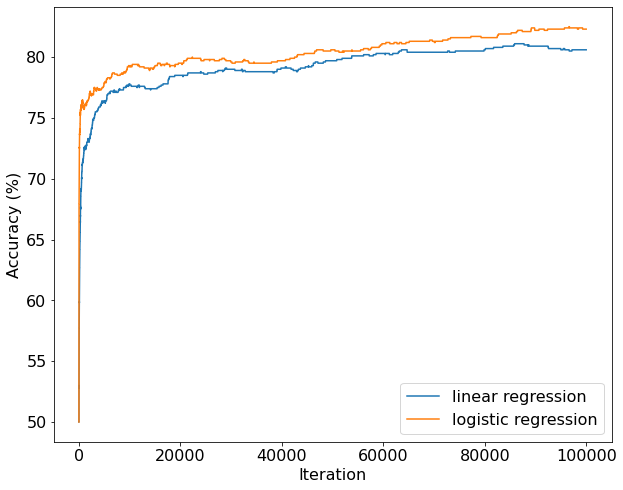

In [177]:
plt.plot(linear_val_accs, label='linear regression')
plt.plot(logistic_val_accs, label='logistic regression')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.show()

### Visualize the weights

Visualize the learned weights for each class. If your implementation is right, the visualization should be close to the average of the images.

(-0.5, 31.5, 31.5, -0.5)

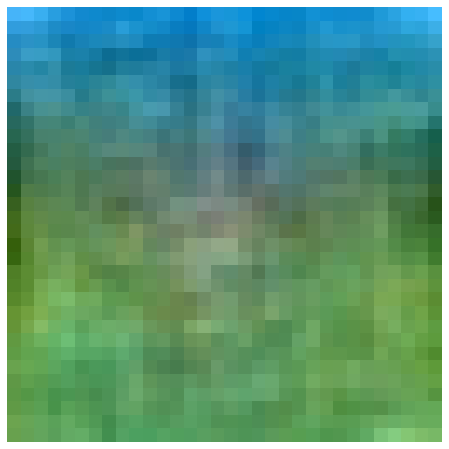

In [178]:
w = best_W.reshape(3, 32, 32)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

wimg = 255.0 * (w - w_min) / (w_max - w_min)

plt.imshow(wimg.type(torch.uint8).cpu())
plt.axis('off')

## Softmax Regression

You need to implement the following functions in `regression.py`:

Softmax is a multi-class classification extension from Logistic Regression . Implement the softmax function:
$$\frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$$

For softmax regression, the loss function is the NLL (negative log likelihood) loss. Implement the loss function :
$$-{\log(p(y))}$$
Here $p(y)$ is a scaler instead of vector. It is the value of the single dimension where the ground truth $y$ lies. It is thus equivalent to cross entropy

Implement the predict function in Softmax Regression class.

In [179]:
from regression import *

x_train, y_train, x_test, y_test = cs188.data.tinyplaces(GOOGLE_DRIVE_PATH, binary=False, use_gpu=True)

regression_model = SoftmaxRegression()

losses = []

best_W = None
best_acc = 0

for i in range(100001):
    y_pred = regression_model.predict(x_train).squeeze()
    acc = regression_model.check_accuracy(x_test, y_test, quiet=True)

    loss = regression_model.get_loss(y_pred, y_train)
    losses.append(loss)
    loss.backward()

    if acc > best_acc:
      best_W = regression_model.W
      best_acc = acc

    if i % 1000 == 0:
      print ("%d/500000 iteration"%i)

      print ("test accuracy is %f"%acc)

    with torch.no_grad():
      regression_model.W -= regression_model.W.grad * 1e-4
      regression_model.b -= regression_model.b.grad * 1e-4
      regression_model.W.grad.zero_()
      regression_model.b.grad.zero_()

0/500000 iteration
test accuracy is 5.000000
1000/500000 iteration
test accuracy is 8.600000
2000/500000 iteration
test accuracy is 11.500000
3000/500000 iteration
test accuracy is 13.500000
4000/500000 iteration
test accuracy is 13.900000
5000/500000 iteration
test accuracy is 14.400000
6000/500000 iteration
test accuracy is 14.700000
7000/500000 iteration
test accuracy is 15.200000
8000/500000 iteration
test accuracy is 15.900000
9000/500000 iteration
test accuracy is 16.200000
10000/500000 iteration
test accuracy is 16.500000
11000/500000 iteration
test accuracy is 16.800000
12000/500000 iteration
test accuracy is 17.200000
13000/500000 iteration
test accuracy is 17.300000
14000/500000 iteration
test accuracy is 17.900000
15000/500000 iteration
test accuracy is 18.100000
16000/500000 iteration
test accuracy is 18.300000
17000/500000 iteration
test accuracy is 18.400000
18000/500000 iteration
test accuracy is 18.700000
19000/500000 iteration
test accuracy is 18.600000
20000/500000 it

### Visualize Weight

Now, visualize the weight for each class. If your implementation is right, the weight of each class should be equivalent to the average of the images of that class.

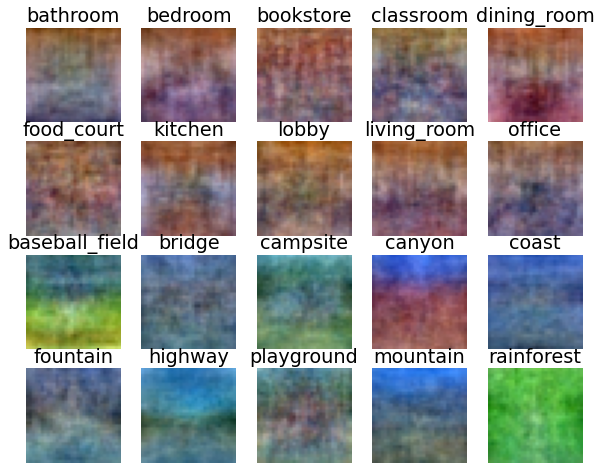

In [180]:
w = best_W.reshape(3, 32, 32, 20)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['bathroom', 'bedroom', 'bookstore', 'classroom', 'dining_room', 'food_court', 'kitchen', 'lobby', 'living_room', 'office', 'baseball_field', 'bridge', 'campsite', 'canyon', 'coast', 'fountain', 'highway', 'playground', 'mountain', 'rainforest']
for i in range(20):
  plt.subplot(4,5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])

# What's the difference between Linear Regression, Logistic Regression and Softmax Regression? (Write down your answer below)

**Your Answer**: In linear regression, we are simply fitting our function/classifier to data, usually continuous. As such, although we can use it for binary categorical data, it is not very well suited. On the other hand, with the use of a sigmoid function (which "forces" output values to one category or another much faster), logistic regression much better handles this binary categorical data, and is much better suited for this case of classifying inputs into one of two categories. Finally, softmax regression is the extension of logistic regression to an arbitrary number of categories, and is able to handle any arbitrary number of categories, instead of just binary categorization.